#### Imports

In [ ]:
#!pip install mltu
#!pip install albumentations

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 94.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.1 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6466 sha256=83a688139b0b9c9b10aab6fd6b7f3fb2e0fc15c30719f83ae5656689b532df9f
  Stored in directory: /root/.cache/pip/wheels/40/1a/56/5dccdea123a172661eb65c8c29fde4567dbda2b72b5fc5893a
Successfully built qqdm
  Attempting uninstall: jupyter-lsp
    Found existing installation: jupyter-lsp 1.5.1
    Uninstalling jupyter-lsp-1.5.1:
      Successfully uninstalled jupyter-lsp-1.5.1


In [1]:
import os
import random
import numpy as np
from zipfile import ZipFile
from PIL import Image
import json
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Bidirectional, LSTM, Reshape, Lambda, StringLookup, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Bidirectional, LSTM, Dropout, Dense, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences

from mltu.tensorflow.model_utils import residual_block
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.metrics import CWERMetric
from mltu.utils.text_utils import ctc_decoder

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Directories

In [4]:
## JANGAN LUPA GANTI DIREKTORI SESUAI ENTAR YANG DI KAGGLE
ROOT_DIR = os.getcwd()
DATASET_DIR = './dataset'
TRAIN_DIR  =os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "test")
TRAIN_METADATA_PATH = os.path.join(TRAIN_DIR, "metadata.jsonl")
VAL_METADATA_PATH = os.path.join(VAL_DIR, "metadata.jsonl")
PRETRAINED_MODEL_PATH = '/kaggle/input/pretrained-model/trained_models/functional_1.keras'
PRETRAINED_WEIGHTS_PATH = '/kaggle/input/pretrained-model/best_weights_75_Ivan.keras'
TRAINED_MODEL_PATH = os.path.join("trained_models")

In [ ]:
print("Daftar file dalam folder dataset:")
print(os.listdir(DATASET_DIR))

print("Memeriksa keberadaan file ZIP...")
print(f"File train.zip ada: {os.path.exists(TRAIN_ZIP_PATH)}")
print(f"File test.zip ada: {os.path.exists(VAL_ZIP_PATH)}")

def extract_zip(zip_path, extract_to):
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)  # Ekstrak ke folder yang ditentukan
        print(f"File {zip_path} telah diekstrak ke {extract_to}.")
    else:
        print(f"File ZIP tidak ditemukan: {zip_path}")

extract_zip(TRAIN_ZIP_PATH, DATASET_DIR)
extract_zip(VAL_ZIP_PATH, DATASET_DIR)

In [5]:
print(len(os.listdir(TRAIN_DIR)))
print(len(os.listdir(VAL_DIR)))

33627
18705


#### Params

In [6]:
BATCH_SIZE = 64
IMAGE_SIZE = (64, 256)
BUFFER_SIZE = 1000
LEARNING_RATE = 0.0001

In [7]:
def load_json_data(file_path):
    image_data = []
    text_data = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line.strip())
                image_data.append(data['file_name'])
                text_data.append(data['text'])
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    
    return image_data, text_data

#### Preprocessing Images

In [8]:
def preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])  # Ensure the shape is defined
    image = tf.image.resize(image, target_size)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.int32)
    return image

def load_images_as_tensor(data_json, image_size, subset):
    dataset = tf.data.Dataset.from_tensor_slices(data_json)
 
    if subset == "train":
        preprocess_fn = lambda img: preprocess_image(
            tf.strings.join([TRAIN_DIR, img], separator=os.path.sep), image_size
        )
    else:
        preprocess_fn = lambda img: preprocess_image(
            tf.strings.join([VAL_DIR, img], separator=os.path.sep), image_size
        )

    dataset = dataset.map(
        preprocess_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return dataset

In [9]:
train_image_data, train_text_data = load_json_data(TRAIN_METADATA_PATH)
val_image_data, val_text_data = load_json_data(VAL_METADATA_PATH)

#### Vectorizer Settings

In [10]:
char_set = list('0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,!?@$&()[]{}:;/- ')

added_tokens = ['[START]', '[END]']
added_tokens_len = sum(len(token) for token in added_tokens)

max_len_text_t = max(train_text_data, key=len)
max_len_t = len(max_len_text_t) + added_tokens_len

max_len_text = max(val_text_data, key=len)
max_len = len(max_len_text) + added_tokens_len

vocab_size = len(char_set) + 2

print(f"Vocab size: {vocab_size}")
print(f"Maximum raw text length val: {max_len}")
print(f"Maximum raw text length train: {max_len_t}")

char_to_num = StringLookup(
    vocabulary = list(char_set),
    mask_token = None
)

num_to_char = StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None, 
    invert = True
)

Vocab size: 82
Maximum raw text length val: 81
Maximum raw text length train: 80


#### Preprocessing Texts

In [11]:
def preprocess_text(text, pad_max_len, pad_value):
    tokenized_text = tf.strings.join(['[START]', text, '[END]'])
    #print(f"tokenized_text: length: {tf.strings.length(tokenized_text).numpy()}")
    split_text = tf.strings.unicode_split(tokenized_text, input_encoding='UTF-8') 
    #print(f"tokenized_text splitted with tf.strings: length: {tf.size(split_text).numpy()}") 
    vectorized_text = char_to_num(split_text)
    padded_text = tf.pad(vectorized_text, paddings=[[0, pad_max_len - tf.size(vectorized_text)]], constant_values=pad_value)
    return padded_text

def text_decoder(tokenized_text, pad_value):
    decoded_text = num_to_char(tokenized_text)
    decoded_text = tf.where(tokenized_text == pad_value, '', decoded_text)
    decoded_text = tf.strings.reduce_join(decoded_text, axis=-1, separator='')
    return decoded_text.numpy().decode('utf-8')

def load_text_to_tensor(data_text_json, pad_max_len, pad_value):
    dataset = tf.data.Dataset.from_tensor_slices(data_text_json)
    dataset = dataset.map(
        lambda text: preprocess_text(text, pad_max_len, pad_value),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset

#### Creating The Dataset

In [12]:
import albumentations as A
import tensorflow as tf
import numpy as np

albumentations_augmentation = A.Compose([        
    A.RandomBrightnessContrast(brightness_limit=0.2, p=0.3),    
    A.GridDistortion(num_steps=10, distort_limit=(-0.5, 0.9), p=0.2),
    A.ShiftScaleRotate(rotate_limit=15, p=0.3),
    A.Affine(translate_percent=0, rotate=0.1, shear=0.2, p=0.3),
    A.GaussianBlur(blur_limit=(0,99), sigma_limit=3, p=0.3),
    A.GaussNoise(var_limit=(0, 1000), p=0.2),
    A.ElasticTransform(alpha=40, sigma=10, p=0.3),
    A.Morphological(scale=(2,7), p=0.4),
    A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1])           
])

def albumentations_augment(image, label, repeat=3):
    image = image.numpy().astype(np.uint8)
    label = label.numpy()
    
    augmented_images = []
    augmented_labels = []
    
    for _ in range(repeat):
        # Apply augmentation
        augmented = albumentations_augmentation(image=image)
        augmented_image = augmented['image']
        
        # Convert back to tensor
        augmented_image = tf.convert_to_tensor(augmented_image, dtype=tf.float32)
        augmented_label = tf.convert_to_tensor(label, dtype=tf.int64)
        
        augmented_images.append(augmented_image)
        augmented_labels.append(augmented_label)
    
    # Stack augmented images and labels
    augmented_images_tensor = tf.stack(augmented_images)
    augmented_labels_tensor = tf.stack(augmented_labels)
    
    return augmented_images_tensor, augmented_labels_tensor

def tf_albumentations_augment(image, label, repeat=1):
    augmented_images, augmented_labels = tf.py_function(
        func=albumentations_augment, 
        inp=[image, label, repeat], 
        Tout=[tf.float32, tf.int64]
    )
    
    augmented_images.set_shape([repeat, IMAGE_SIZE[0], IMAGE_SIZE[1], 1])
    augmented_labels.set_shape([repeat, max_len])
    
    return augmented_images, augmented_labels

def apply_augmentation(dataset, repeat=3):
    return dataset.map(
        lambda image, label: tf_albumentations_augment(image, label, repeat),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()

c:\Users\NAN0C\.virtualenvs\Receipt_model-OqGzILDq\Lib\site-packages\pydantic\main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


#### Image Augmentation

In [13]:
def load_dataset(data_path, subset, image_size, pad_max_len, pad_value) :
    images, texts = load_json_data(data_path)
    images_t = load_images_as_tensor(images, image_size, subset)
    texts_t = load_text_to_tensor(texts, pad_max_len, pad_value)
    
    dataset = tf.data.Dataset.zip((images_t, texts_t))
    augmented_dataset = apply_augmentation(dataset, repeat=1)
    final_dataset = (augmented_dataset
         .shuffle(buffer_size=BUFFER_SIZE)
         .cache()
         .batch(batch_size=BATCH_SIZE)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
     )
    return final_dataset

In [14]:
train_ds = load_dataset(TRAIN_METADATA_PATH, "train", IMAGE_SIZE, max_len, vocab_size)
val_ds = load_dataset(VAL_METADATA_PATH, "val", IMAGE_SIZE, max_len, vocab_size)

train_cardinality = train_ds.cardinality().numpy()
val_cardinality = val_ds.cardinality().numpy()

print(f"Train dataset total data: {train_cardinality * BATCH_SIZE}")
print(f"Validation dataset total data: {val_cardinality * BATCH_SIZE}")

Train dataset total data: 33664
Validation dataset total data: 18752


In [15]:
# image_error = train_image_data[67]
# text_error = train_text_data[67]
# image_path = os.path.join(TRAIN_DIR, image_error)
# image = Image.open(image_path)

# plt.imshow(image)
# plt.axis('off') 
# plt.title(text_error)
# plt.show()

# print(len(text_error))
# print(len(char_to_num(list(text_error))))
# test = preprocess_text(text_error, max_len, vocab_size)
# print(test)
# print(text_decoder(test, vocab_size))

# #BROKEN IMAGE index: 12466 

In [16]:
# num_images_to_test = len(val_text_data)  # Number of images to test

# for idx, (image, text) in enumerate(val_ds.take(num_images_to_test)):
#     print(f"Index {idx}:")
#     print(f"Text shape: {text.shape}")
#     # Print the associated text for reference
#     print(f"Text: {text_decoder(text, vocab_size)}")


In [17]:
print(len(train_ds))

for image, text in train_ds.take(1):
    sample_text = text[0]
    print(f"image shape: {image.shape}")
    print(f"text shape: {text.shape}")
    print(sample_text)
    print(text_decoder(sample_text, vocab_size))


526
image shape: (64, 64, 256, 1)
text shape: (64, 81)
tf.Tensor(
[72 55 56 37 54 56 73 38 51 52 52 80 56 37 52 41 80  5  9 49 49  0  2  1
  1 49 80 39 48 41 37 54 72 41 50 40 73 82 82 82 82 82 82 82 82 82 82 82
 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82
 82 82 82 82 82 82 82 82 82], shape=(81,), dtype=int64)
[START]BOPP TAPE 48MM[UNK]100M CLEAR[END]


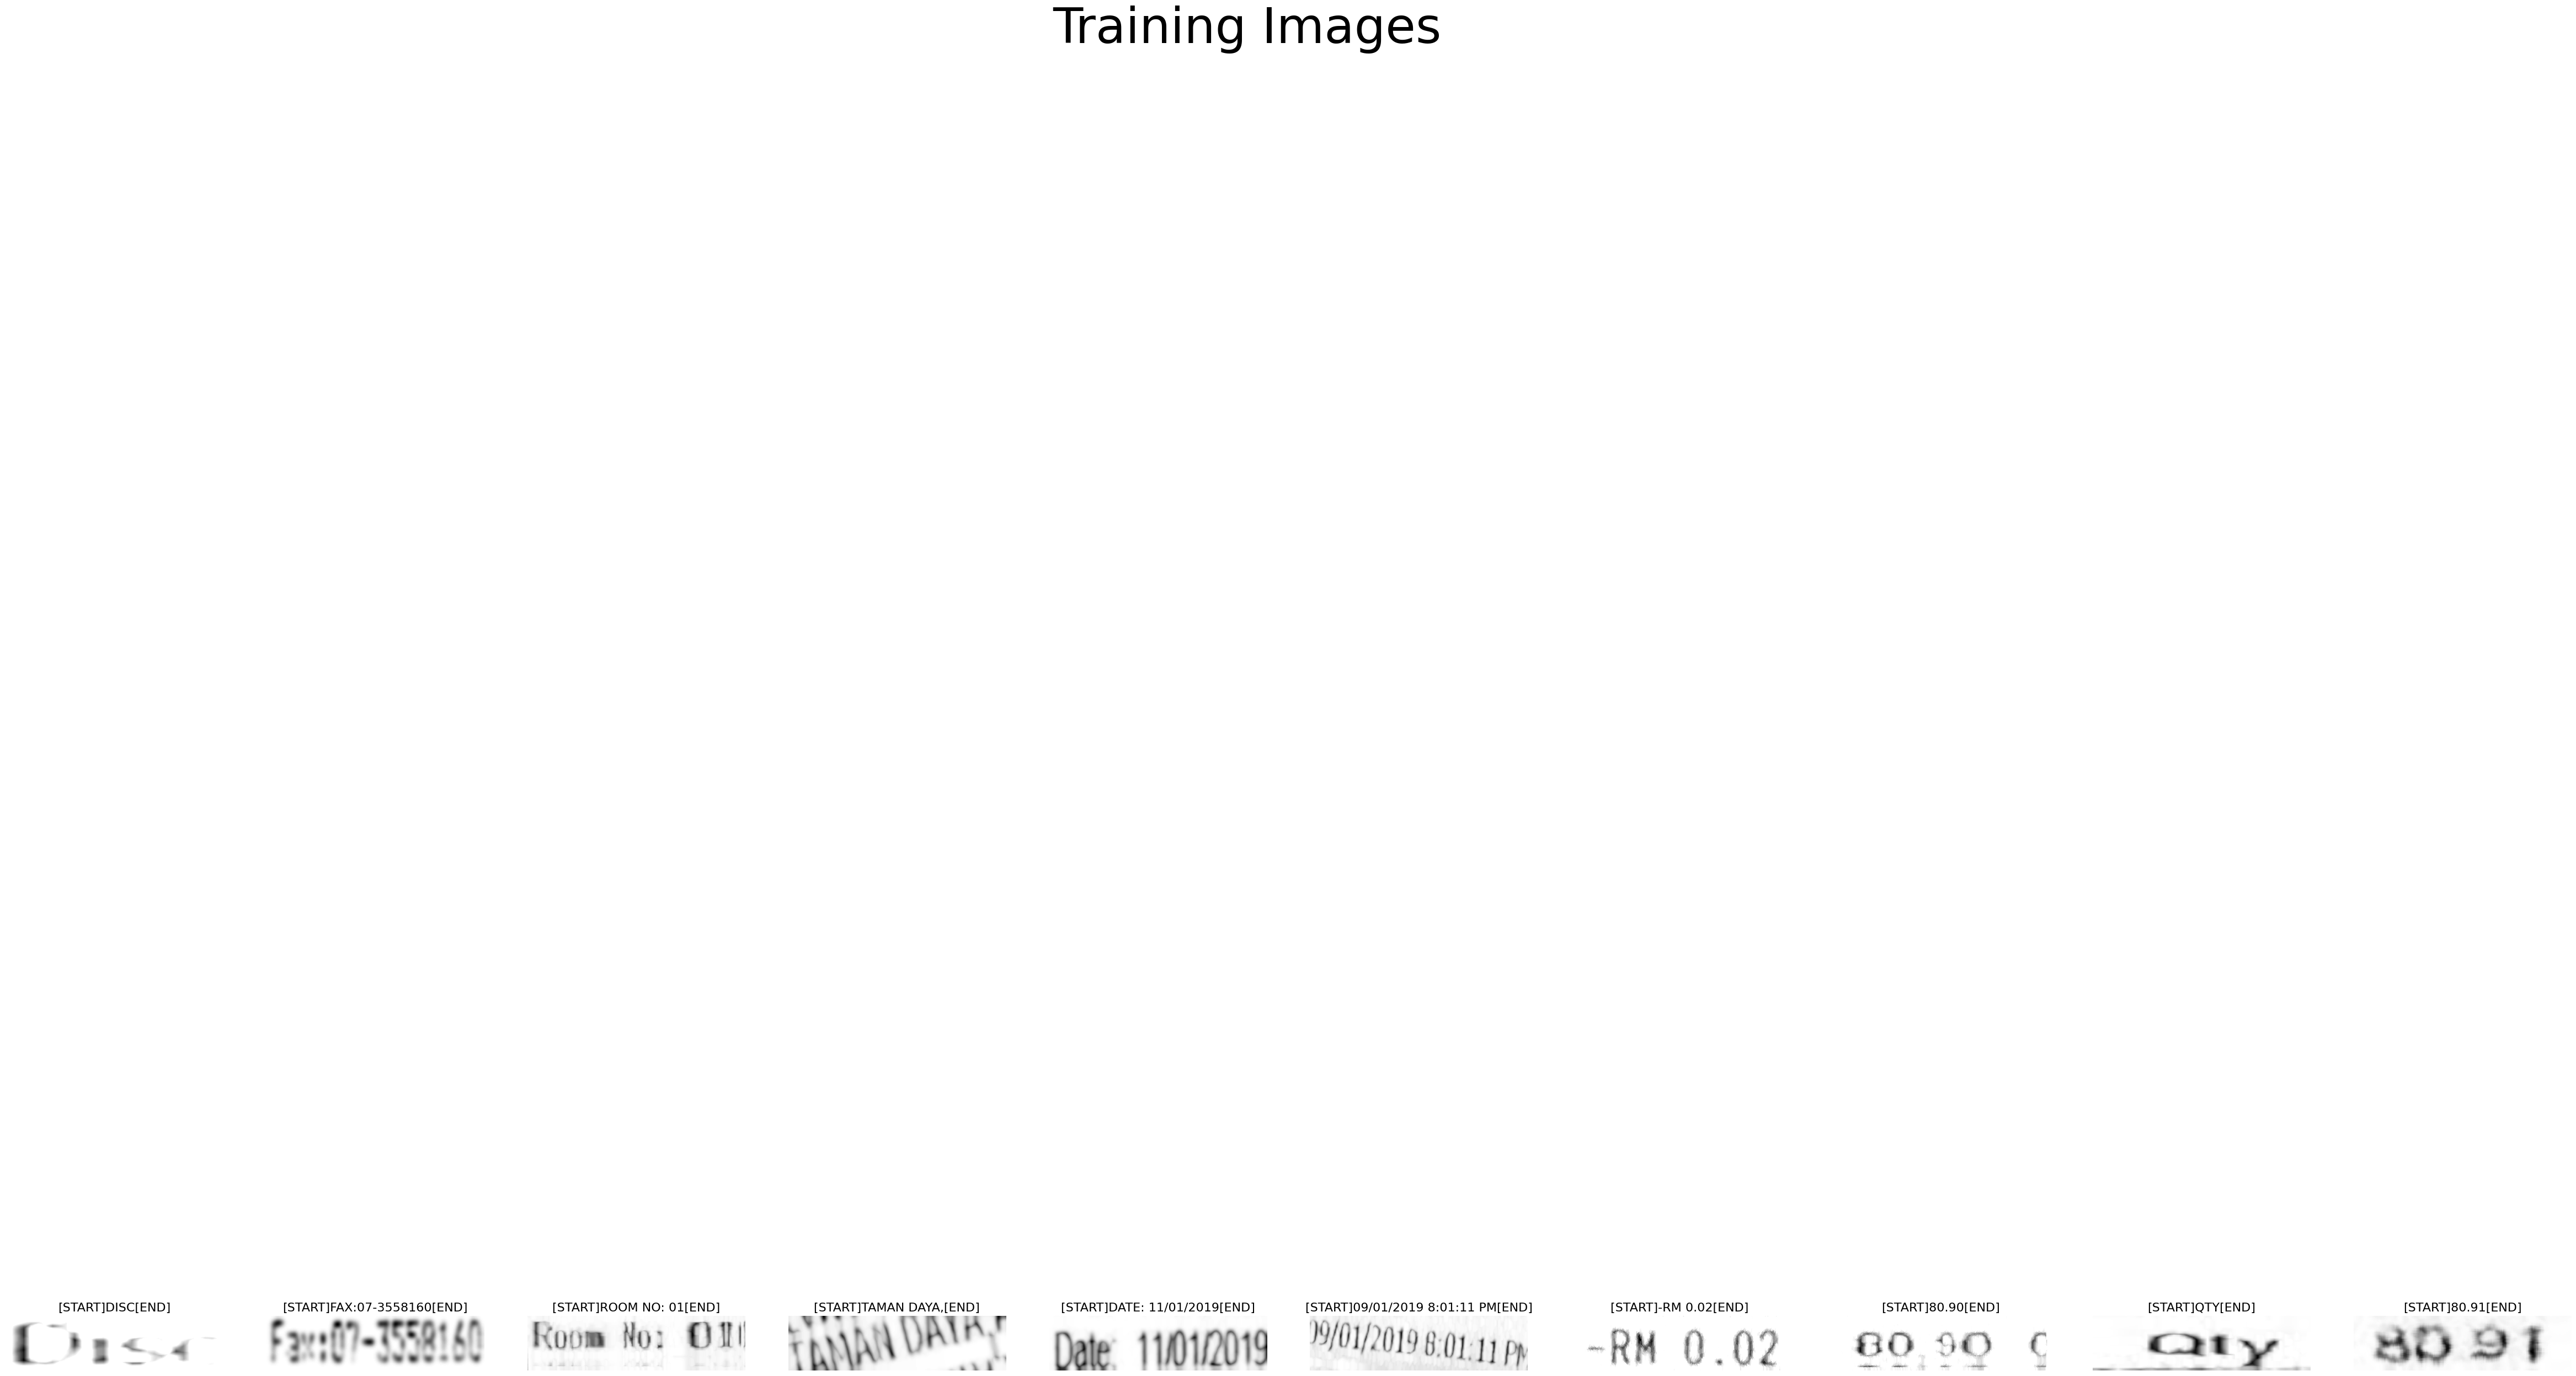

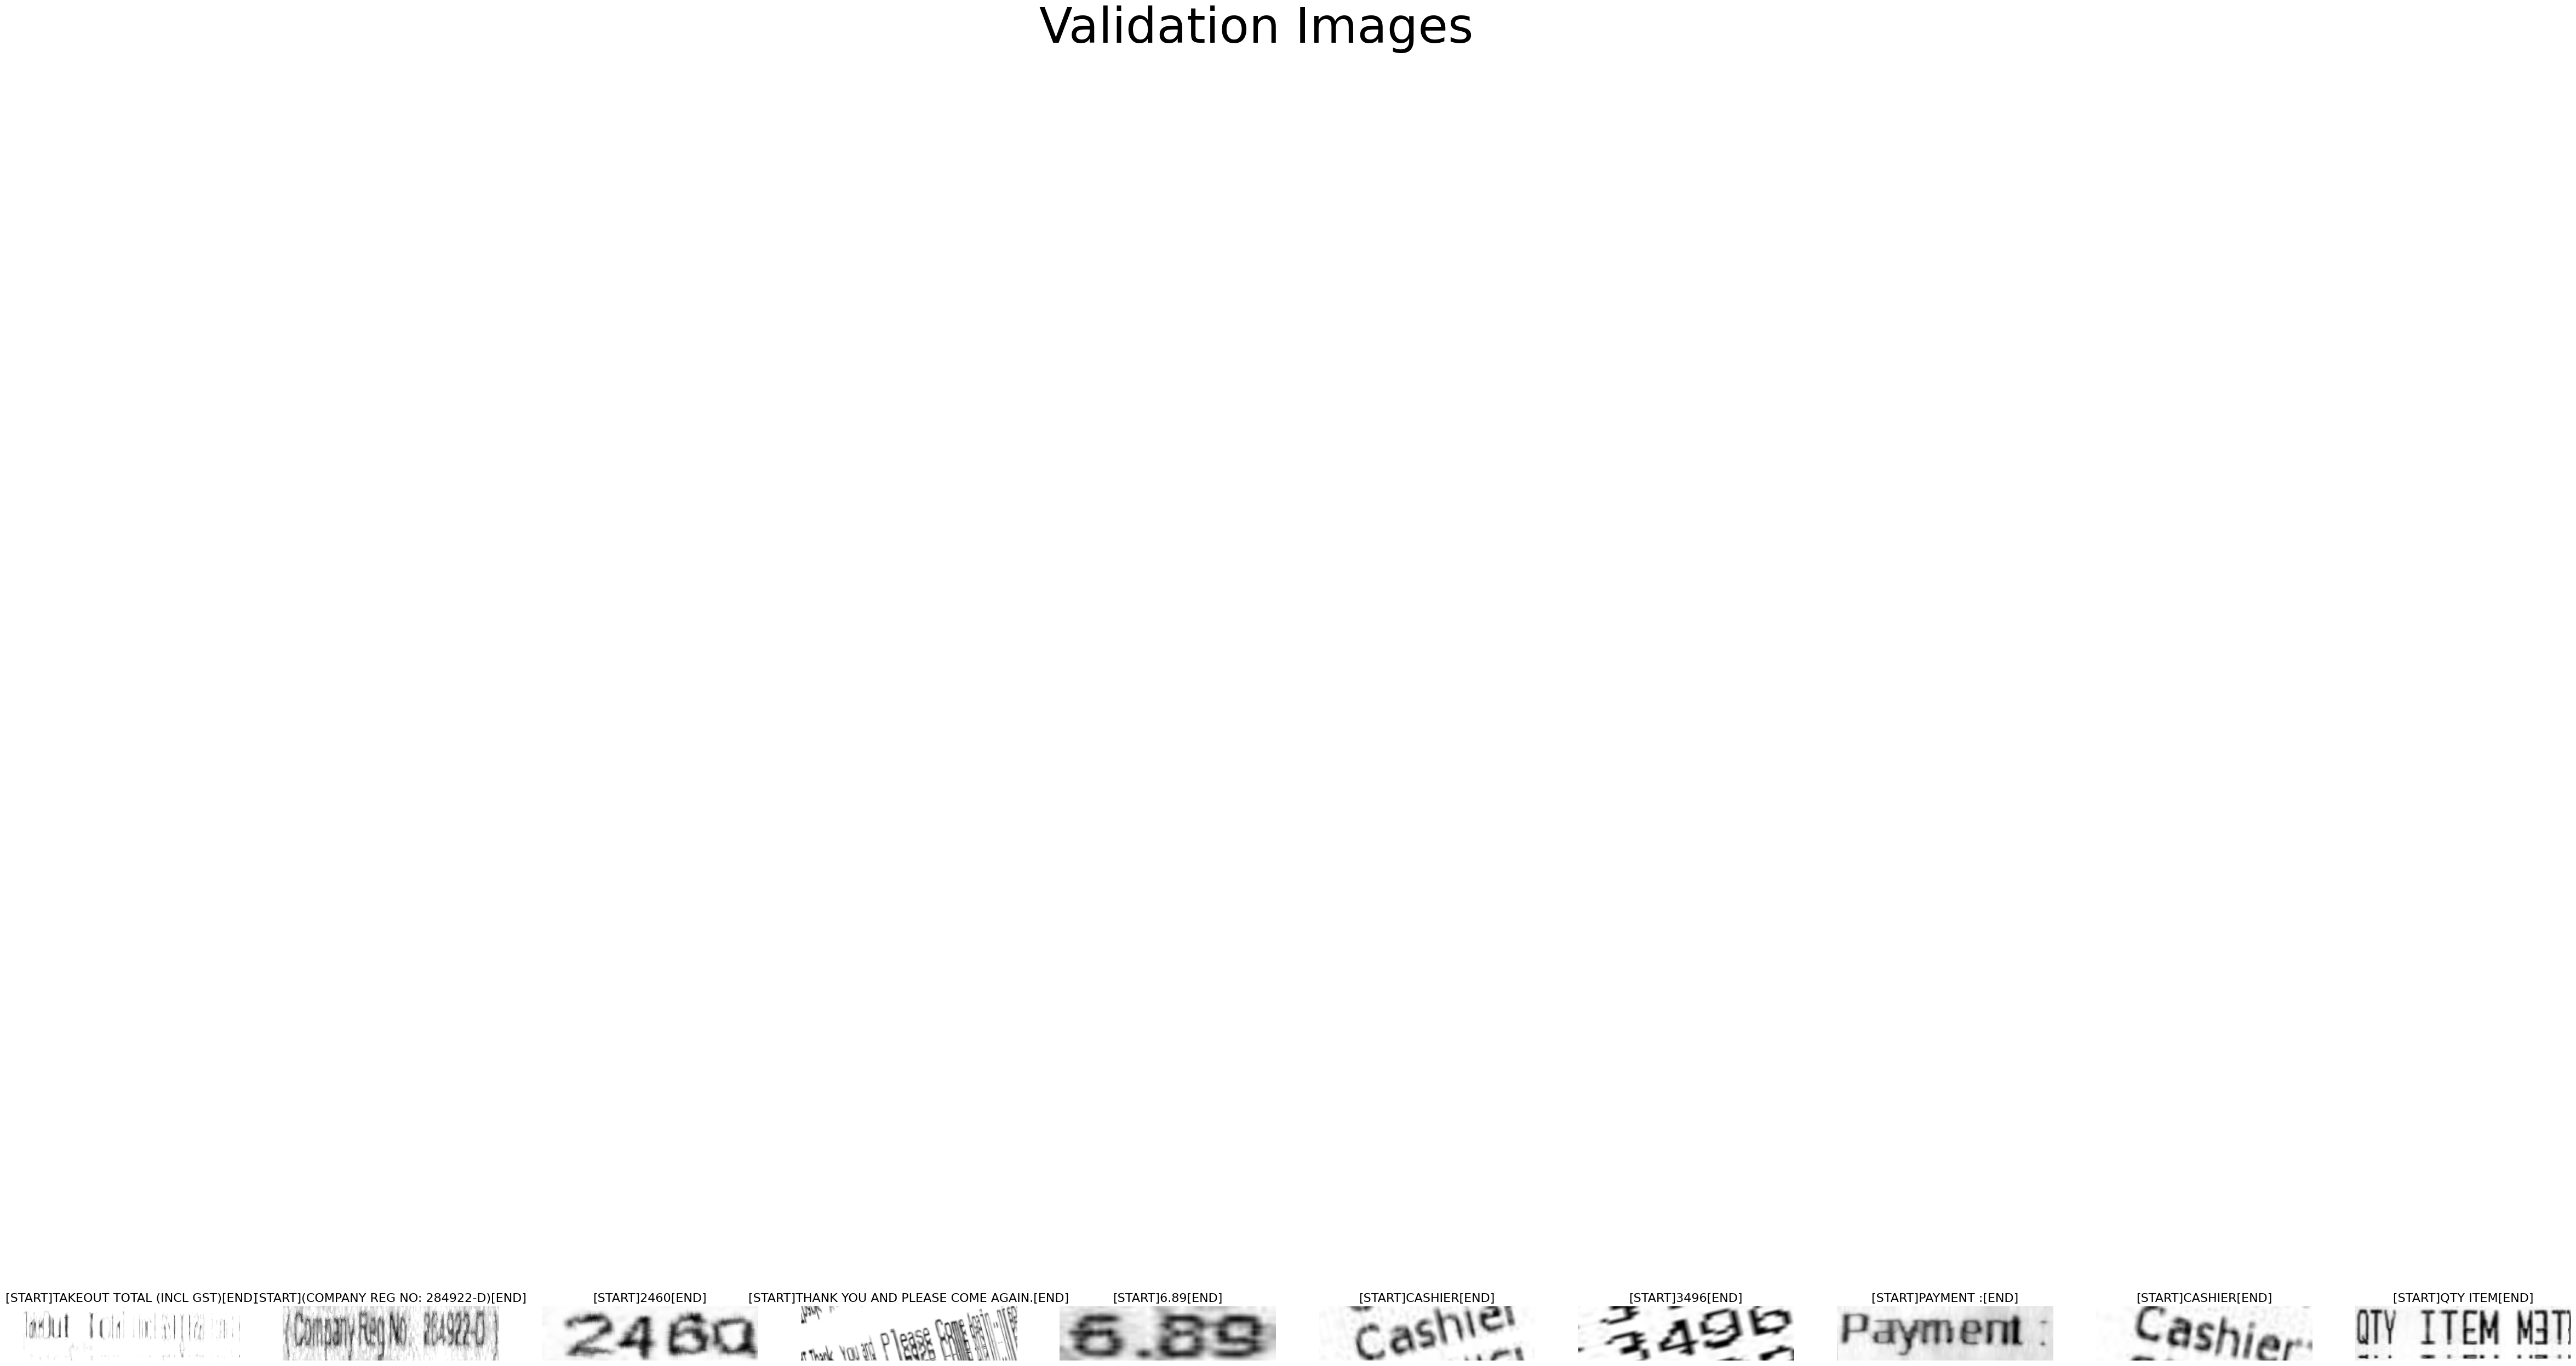

In [18]:
def plot_images_with_titles(dataset, num_images, title="Images", figsize=(60, 50)):
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    for idx, (image, text) in enumerate(dataset.take(1)):
        if idx >= num_images:
            break

        for i in range(min(num_images, image.shape[0])):  
            single_img = image[i]  
            single_text = text[i]
            text_title = text_decoder(single_text, vocab_size) 
            axes[i].imshow(single_img.numpy().squeeze(), cmap='gray')
            axes[i].set_title(text_title, fontsize=16) 
            axes[i].axis('off')

    plt.suptitle(title, fontsize=64)
    plt.show()


plot_images_with_titles(train_ds, num_images=10, title="Training Images")
plot_images_with_titles(val_ds, num_images=10, title="Validation Images")

#### Creating Model

In [18]:
def load_crnn_model(input_dim, output_dim, activation='relu', dropout=0.3):
    inputs = Input(shape=input_dim, name="input")
    inputs_normalized = Lambda(lambda x: x / 255.0)(inputs)  # Normalizing input to [0, 1]
    
    c_1 = Conv2D(32, (3, 3), activation=activation, padding='same', name='conv_1')(inputs_normalized)
    c_2 = Conv2D(32, (3, 3), activation=activation, padding='same', name='conv_2')(c_1)
    c_3 = Conv2D(64, (3, 3), activation=activation, padding='same', name='conv_3')(c_2)
    bn_3 = BatchNormalization(name='bn_3')(c_3)
    p_3 = MaxPooling2D(pool_size=(2, 2), name='maxpool_3')(bn_3)

    c_4 = Conv2D(64, (3, 3), activation=activation, padding='same', name='conv_4')(p_3)
    c_5 = Conv2D(64, (3, 3), activation=activation, padding='same', name='conv_5')(c_4)
    bn_5 = BatchNormalization(name='bn_5')(c_5)
    p_5 = MaxPooling2D(pool_size=(2, 2), name='maxpool_5')(bn_5)

    c_6 = Conv2D(128, (3, 3), activation=activation, padding='same', name='conv_6')(p_5)
    c_7 = Conv2D(128, (3, 3), activation=activation, padding='same', name='conv_7')(c_6)
    bn_7 = BatchNormalization(name='bn_7')(c_7)

    reshaped_output = Reshape((bn_7.shape[1] * bn_7.shape[2], bn_7.shape[-1]))(bn_7)
    
    # Add Bidirectional LSTM layers to capture sequential patterns
    blstm_8 = Bidirectional(LSTM(32, kernel_initializer="he_normal", return_sequences=True))(reshaped_output)
    blstm_8 = Bidirectional(LSTM(64, kernel_initializer="he_normal", return_sequences=True))(reshaped_output)
    do_10 = Dropout(dropout, name='dropout')(blstm_8)
    
    output = Dense(output_dim + 1, activation='softmax', name="output")(do_10)

    # Create and return the model
    model = Model(inputs=inputs, outputs=output)
    return model

#### CTC Loss and CWER Metrics

In [20]:
class CTCloss(tf.keras.losses.Loss):
    """ CTCLoss object for training the model """
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name: str = "CTCloss") -> None:
        super(CTCloss, self).__init__(name=name)
        self.reduction = reduction
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None) -> tf.Tensor:
        """ Compute the training batch CTC loss value """
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        # Calculate CTC loss using the built-in ctc_batch_cost function
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        # Apply reduction (if necessary)
        if self.reduction == tf.keras.losses.Reduction.NONE:
            return loss
        elif self.reduction == tf.keras.losses.Reduction.SUM:
            return tf.reduce_sum(loss)
        elif self.reduction == tf.keras.losses.Reduction.AUTO:
            return tf.reduce_mean(loss)
        else:
            return loss  

class CWERMetric(tf.keras.metrics.Metric):
    """A custom TensorFlow metric to compute the Character Error Rate (CER).
    
    Args:
        padding_token: An integer representing the padding token in the input data.
        name: (Optional) string name of the metric instance.
        **kwargs: Additional keyword arguments.
    """
    def __init__(self, padding_token=0, name="CWER", **kwargs):
        # Initialize the base Metric class
        super(CWERMetric, self).__init__(name=name, **kwargs)
        
        # Initialize variables to keep track of the cumulative character/word error rates and counter
        self.cer_accumulator = tf.Variable(0.0, name="cer_accumulator", dtype=tf.float32)
        self.wer_accumulator = tf.Variable(0.0, name="wer_accumulator", dtype=tf.float32)
        self.batch_counter = tf.Variable(0, name="batch_counter", dtype=tf.int32)
        
        # Store the padding token as an attribute
        self.padding_token = padding_token

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Updates the state variables of the metric.

        Args:
            y_true: A tensor of true labels with shape (batch_size, sequence_length).
            y_pred: A tensor of predicted labels with shape (batch_size, sequence_length, num_classes).
            sample_weight: (Optional) a tensor of weights with shape (batch_size, sequence_length).
        """
        # Get the input shape and length
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0], dtype="int32") * tf.cast(input_shape[1], "int32")

        # Decode the predicted labels using greedy decoding
        decode_predicted, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)

        # Convert the dense decode tensor to a sparse tensor
        predicted_labels_sparse = tf.keras.backend.ctc_label_dense_to_sparse(decode_predicted[0], input_length)
        
        # Convert the dense true labels tensor to a sparse tensor and cast to int64
        true_labels_sparse = tf.cast(tf.keras.backend.ctc_label_dense_to_sparse(y_true, input_length), "int64")

        # Retain only the non-padding elements in the predicted labels tensor
        predicted_labels_sparse = tf.sparse.retain(predicted_labels_sparse, tf.not_equal(predicted_labels_sparse.values, -1))
        
        # Retain only the non-padding elements in the true labels tensor
        true_labels_sparse = tf.sparse.retain(true_labels_sparse, tf.not_equal(true_labels_sparse.values, self.padding_token))

        # Calculate the normalized edit distance between the predicted labels and true labels tensors
        distance = tf.edit_distance(predicted_labels_sparse, true_labels_sparse, normalize=True)

        # Add the sum of the distance tensor to the cer_accumulator variable
        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        
        # Increment the batch_counter by the batch size
        self.batch_counter.assign_add(input_shape[0])

        # Calculate the number of wrong words in batch and add to wer_accumulator variable
        self.wer_accumulator.assign_add(tf.reduce_sum(tf.cast(tf.not_equal(distance, 0), tf.float32)))

    def result(self):
        """Computes and returns the metric result.

        Returns:
            A dictionary containing the CER and WER.
        """
        return {
                "CER": tf.math.divide_no_nan(self.cer_accumulator, tf.cast(self.batch_counter, tf.float32)),
                "WER": tf.math.divide_no_nan(self.wer_accumulator, tf.cast(self.batch_counter, tf.float32))
        }

#### Training the model

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

model = load_crnn_model((64, 256, 1), vocab_size)
# model = tf.keras.models.load_model(PRETRAINED_MODEL_PATH, safe_mode=False, custom_objects={'CTCloss': CTCloss, 'CWERMetric': CWERMetric})
# model.load_weights(PRETRAINED_WEIGHTS_PATH)
model.name = "CRNN_Model_control"

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), 
    loss=CTCloss(), 
    metrics=[CWERMetric(padding_token=vocab_size)],
    run_eagerly=False
)

earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode='min')
checkpoint = ModelCheckpoint(f"{TRAINED_MODEL_PATH}/{model.name}/weight/best_weight.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
tb_callback = TensorBoard(f"{TRAINED_MODEL_PATH}/{model.name}/log/logs", update_freq=10)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")

model.summary()

Model: "CRNN_Model_control"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 256, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 256, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 64, 256, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64, 256, 64)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 32, 128, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 32, 128, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_5 (BatchNormalization)       │ (None, 32, 128, 64)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_5 (MaxPooling2D)        │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_7 (Conv2D)                 │ (None, 16, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_7 (BatchNormalization)       │ (None, 16, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1024, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1024, 83)       │        10,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,907 (1.66 MB)

 Trainable params: 433,395 (1.65 MB)

 Non-trainable params: 512 (2.00 KB)

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[earlystopper, checkpoint, reduceLROnPlat, tb_callback],
)

KeyboardInterrupt: 

#### METRICS (CER) AND (WER)

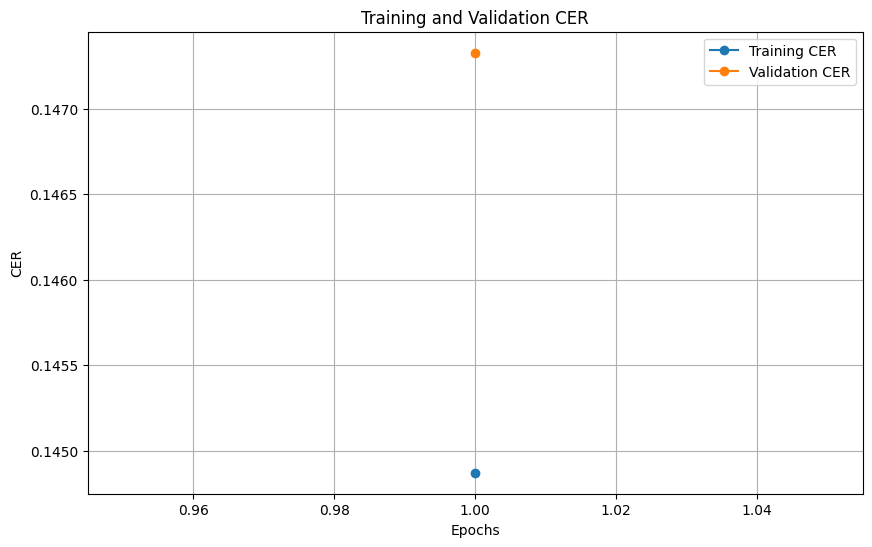

In [23]:
train_cer = history.history['CER']
val_cer = history.history['val_CER']
epochs = list(range(1, len(train_cer) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_cer, label='Training CER', marker='o')
plt.plot(epochs, val_cer, label='Validation CER', marker='o')
plt.title('Training and Validation CER')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.legend()
plt.grid()
plt.show()

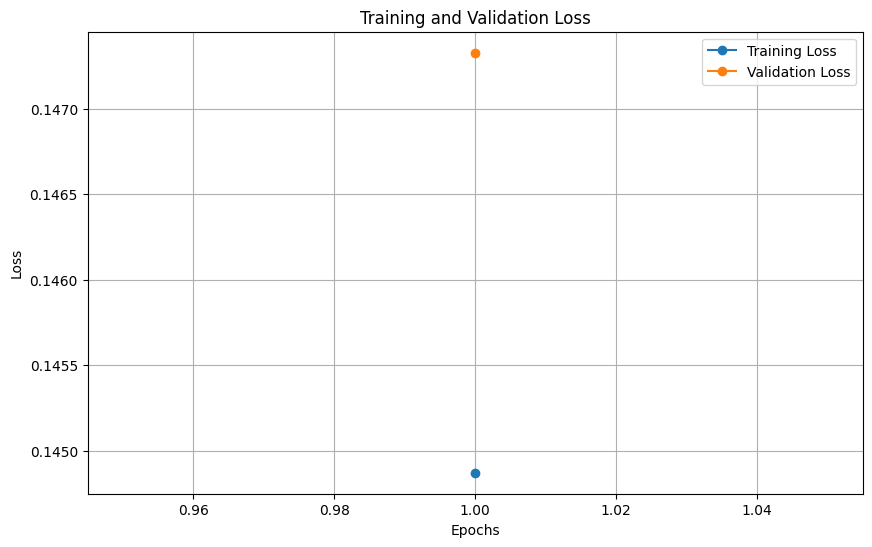

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(range(1, len(train_cer) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_cer, label='Training Loss', marker='o')
plt.plot(epochs, val_cer, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

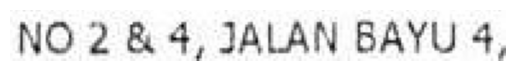

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
[START]NO 2A4, JADAN BAYG 4,[END]


In [25]:
example_image = val_image_data[50]
image_path = os.path.join(VAL_DIR, example_image)
image = Image.open(image_path)

# Plot the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

pre_image = preprocess_image(image_path, IMAGE_SIZE)
pre_image = tf.expand_dims(pre_image, axis=0)

predictions = model.predict(pre_image)
resulted_text = ctc_decoder(predictions, char_to_num.get_vocabulary())[0]
print(resulted_text)

#### Save Model

In [26]:
import os
import shutil
from IPython.display import FileLink

name = model.name + '.keras'
model_save_path = os.path.join(TRAINED_MODEL_PATH, model.name, 'model')
os.makedirs(model_save_path, exist_ok=True)
model.save(os.path.join(model_save_path, name))


zip_path = os.path.join(TRAINED_MODEL_PATH, model.name)
full_zip_path = os.path.join(zip_path, f"{model.name}.zip")
shutil.make_archive(zip_path, 'zip', TRAINED_MODEL_PATH)

# Display a download link
print(f"Zipped model is available for download at: {zip_path}")


Zipped model is available for download at: trained_models/CRNN_Model_augmented


In [31]:
FileLink(os.path.join(TRAINED_MODEL_PATH, f"{model.name}.zip"))

/kaggle/working/trained_models/CRNN_Model_augmented.zip